# ML methods, week 12 demo

## Libraries and settings

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

In [31]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
float_formatter = "{:.4f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

# Diabetes PIMA data

In [4]:
dfo = pd.read_csv("diabetes.csv")
dfo.head(1)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1

In [9]:
dfo.Outcome.value_counts()
# 0 = NOT-diabetic; 1 = diabetic
# target unbalanced but not extremely

Outcome
0    500
1    268
Name: count, dtype: int64

In [6]:
dfo.dtypes.value_counts()
# features are all numeric so no need for label encoding 

int64      7
float64    2
Name: count, dtype: int64

In [4]:
dfo.isnull().values.any()
# no nulls so can be plotted simply

False

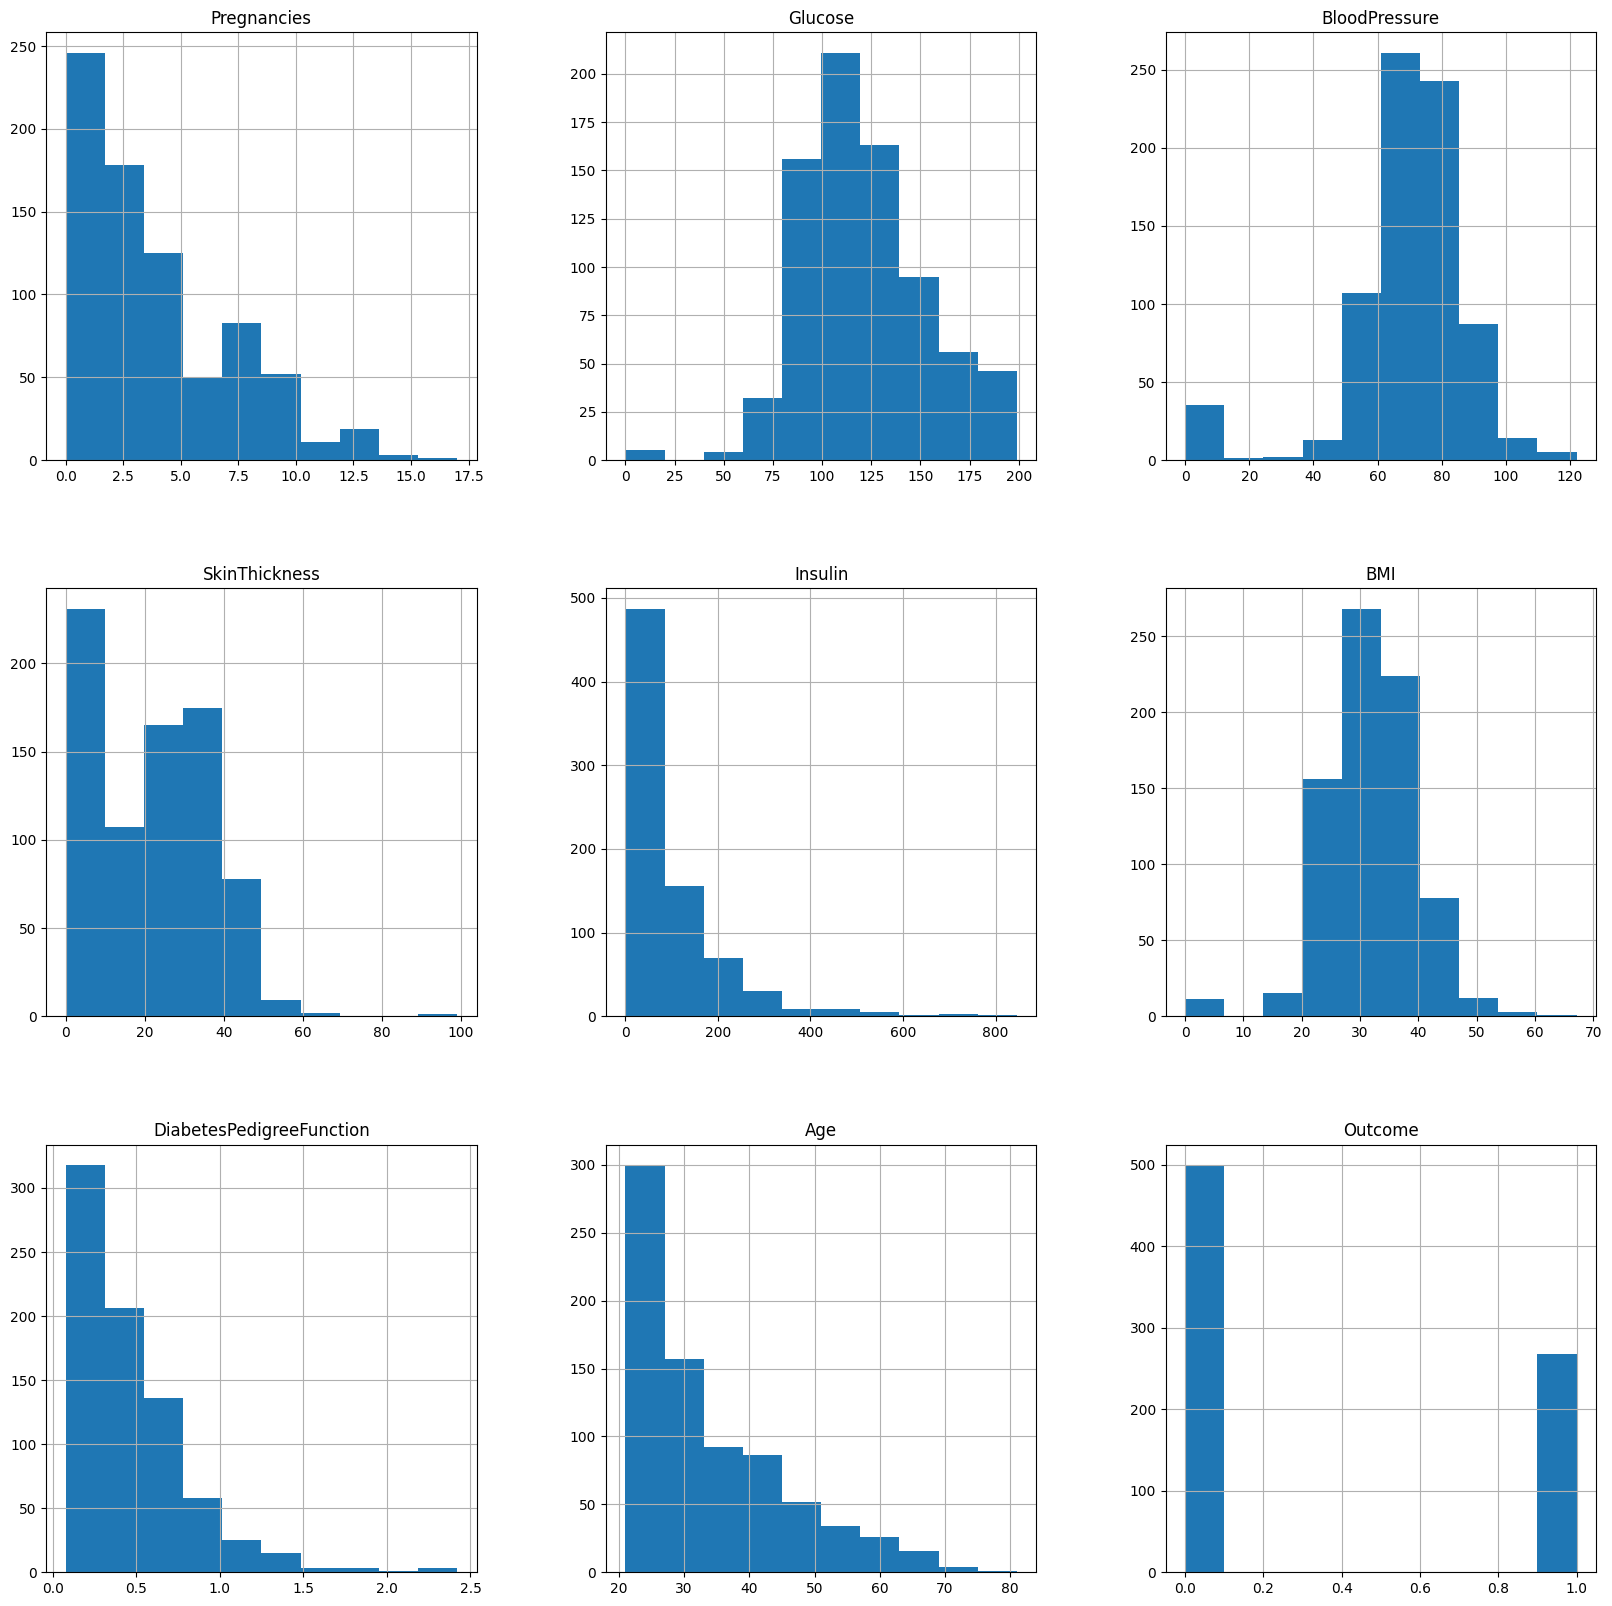

In [5]:
p = dfo.hist(figsize = (20,20))

In [6]:
(dfo == 0).sum()
# nonsense zero values instead of nulls

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

## Cleaning data

In [11]:
# change those zeros to nulls
df = dfo.copy(deep=True)
df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = dfo[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [12]:
df.corr()

Pregnancies   Glucose  BloodPressure  SkinThickness  \
Pregnancies                  1.000000  0.128135       0.214178       0.100239   
Glucose                      0.128135  1.000000       0.223192       0.228043   
BloodPressure                0.214178  0.223192       1.000000       0.226839   
SkinThickness                0.100239  0.228043       0.226839       1.000000   
Insulin                      0.082171  0.581186       0.098272       0.184888   
BMI                          0.021719  0.232771       0.289230       0.648214   
DiabetesPedigreeFunction    -0.033523  0.137246      -0.002805       0.115016   
Age                          0.544341  0.267136       0.330107       0.166816   
Outcome                      0.221898  0.494650       0.170589       0.259491   

                           Insulin       BMI  DiabetesPedigreeFunction  \
Pregnancies               0.082171  0.021719                 -0.033523   
Glucose                   0.581186  0.232771                  0.137246   
BloodPressure             0.098272  0.289230                 -0.002805   
SkinThickness             0.184888  0.648214                  0.115016   
Insulin                   1.000000  0.228050                  0.130395   
BMI                       0.228050  1.000000                  0.155382   
DiabetesPedigreeFunction  0.130395  0.155382                  1.000000   
Age                       0.220261  0.025841                  0.033561   
Outcome                   0.303454  0.313680                  0.173844   

                               Age   Outcome  
Pregnancies               0.544341  0.221898  
Glucose                   0.267136  0.494650  
BloodPressure             0.330107  0.170589  
SkinThickness             0.166816  0.259491  
Insulin                   0.220261  0.303454  
BMI                       0.025841  0.313680  
DiabetesPedigreeFunction  0.033561  0.173844  
Age                       1.000000  0.238356  
Outcome                   0.238356  1.000000

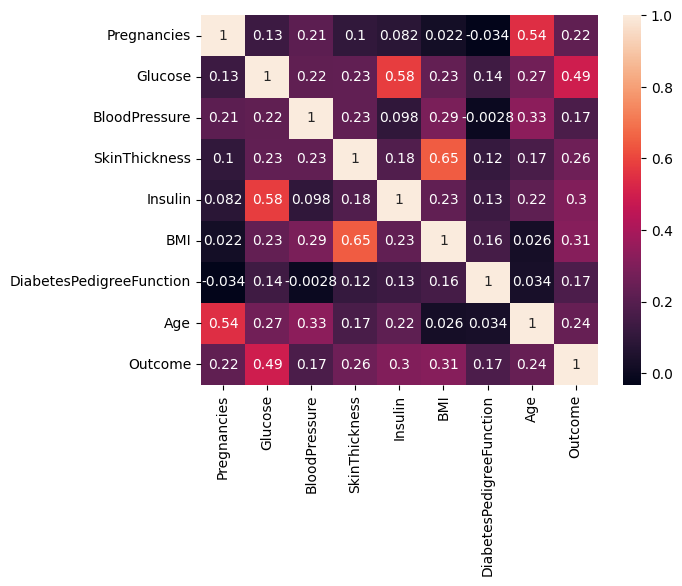

In [13]:
sns.heatmap(df.corr(), annot = True)
plt.show()

In [14]:
# change Nulls to mean of column
# alternative would be to split rows by outcome 0/1 and use two means 
df['Glucose'].fillna(df['Glucose'].mean(), inplace = True)
df['BloodPressure'].fillna(df['BloodPressure'].mean(), inplace = True)
df['SkinThickness'].fillna(df['SkinThickness'].mean(), inplace = True)
df['Insulin'].fillna(df['Insulin'].mean(), inplace = True)
df['BMI'].fillna(df['BMI'].mean(), inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    float64
 2   BloodPressure             768 non-null    float64
 3   SkinThickness             768 non-null    float64
 4   Insulin                   768 non-null    float64
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


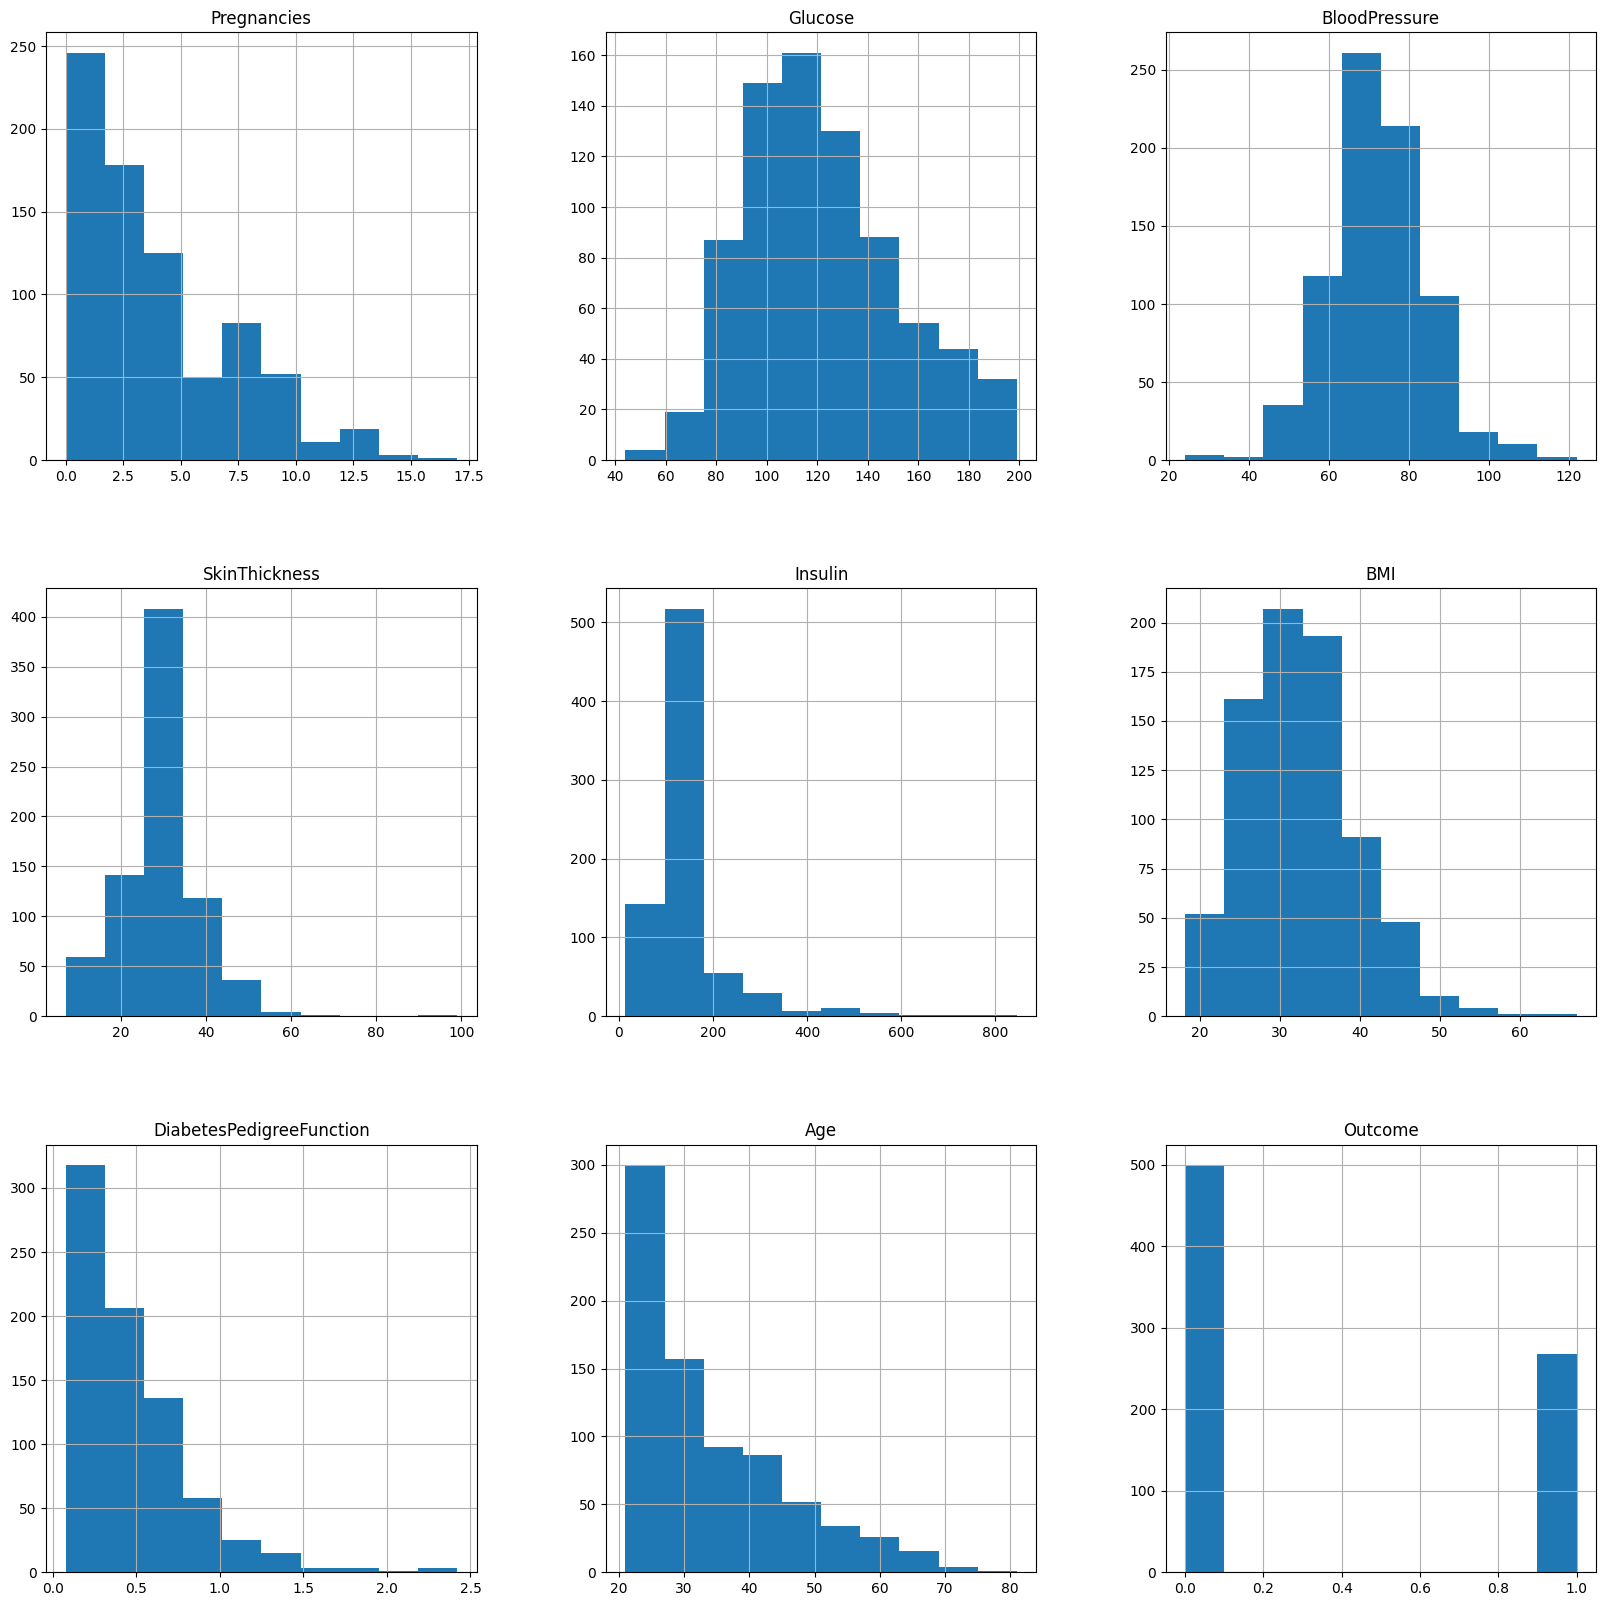

In [16]:
df.hist(figsize = (20,20))
plt.show()
# plot after zero/nulls changed to mean

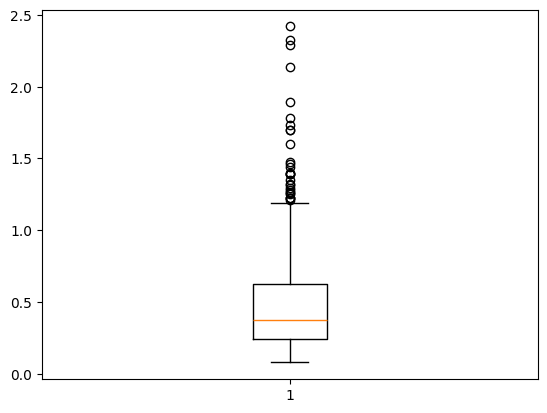

In [81]:
plt.boxplot(df.DiabetesPedigreeFunction)
plt.show() #no extreme outliers 

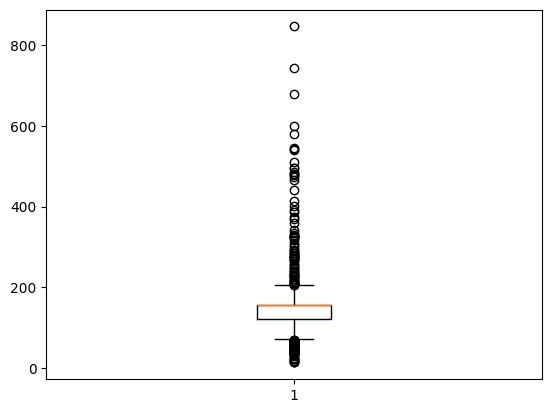

In [80]:
plt.boxplot(df.Insulin)
plt.show() # no extreme outliers

Outcome
0    500
1    268
Name: count, dtype: int64


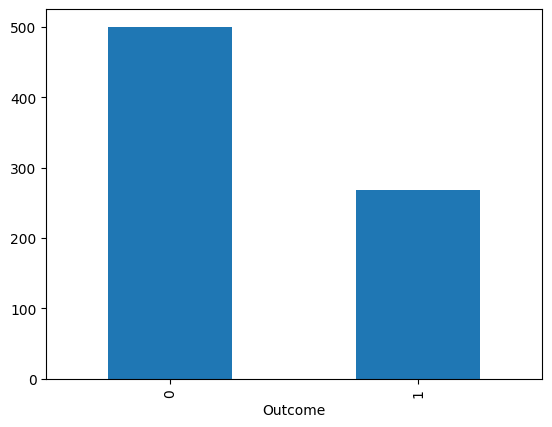

In [79]:
print(df.Outcome.value_counts())
figsize = (4,4)
df.Outcome.value_counts().plot(kind="bar")
plt.show()

## Prepare train & test data

In [17]:
X = df.drop('Outcome', axis=1)
y = np.array(df.Outcome)
y = df.Outcome
print(type(X))
print(X.shape)
print(type(y))
print(y.shape)

<class 'pandas.core.frame.DataFrame'>
(768, 8)
<class 'pandas.core.series.Series'>
(768,)


In [18]:
df_diabetes_zeros_to_mean = df.copy(deep=True)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(type(X_train))
print(X_train.shape)

<class 'pandas.core.frame.DataFrame'>
(614, 8)


In [20]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
print(type(X_train_scaled))
print(X_train_scaled[0])

<class 'numpy.ndarray'>
[-0.5264 -1.2583 0.0132 0.0473 0.0074 0.0150 -0.4907 -1.0359]


In [21]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled[0])

[0.6819 -0.7928 -1.1783 0.5049 0.4038 0.2376 -0.1164 0.8781]


In [22]:
print(type(y_train))
print(y_train[:5])

<class 'pandas.core.series.Series'>
60     0
618    1
346    0
294    0
231    1
Name: Outcome, dtype: int64


## Logistic Regression

In [57]:
model = LogisticRegression(C=0.01, max_iter=200)
model.fit(X_train, y_train)

LogisticRegression(C=0.01, max_iter=200)

In [60]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test_scaled)[:,1]

In [62]:
print("%.4f" % log_loss(y_test, y_pred))

8.4258


In [63]:
confusion_matrix(y_test, y_pred)

array([[83, 16],
       [20, 35]])

In [64]:
print("%.4f" % accuracy_score(y_test, y_pred))

0.7662


In [65]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.84      0.82        99
           1       0.69      0.64      0.66        55

    accuracy                           0.77       154
   macro avg       0.75      0.74      0.74       154
weighted avg       0.76      0.77      0.76       154



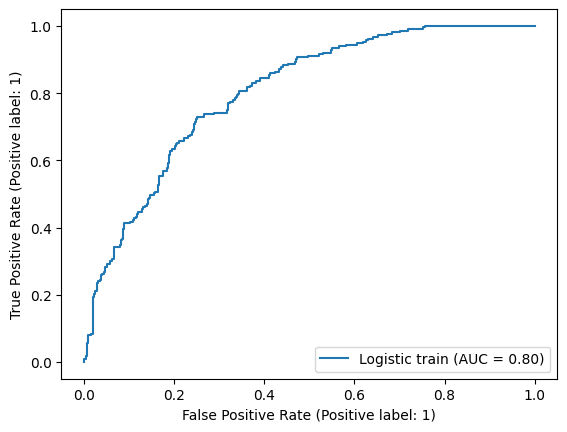

In [66]:
RocCurveDisplay.from_predictions(y_train, model.predict_proba(X_train_scaled)[:,1], name="Logistic train")  
plt.show()  

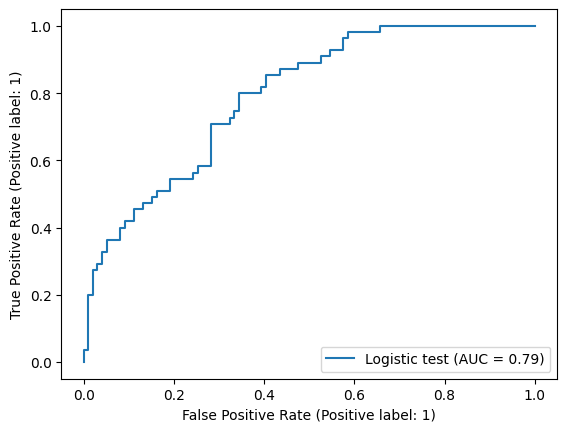

In [67]:
RocCurveDisplay.from_predictions(y_test, model.predict_proba(X_test_scaled)[:,1], name="Logistic test")  
plt.show()  

### Model 2 - L1, Saga, C=0.1 

In [68]:
model2 = LogisticRegression(C=0.1, penalty="l1", solver="saga", max_iter=2000)
model2.fit(X_train, y_train)

LogisticRegression(C=0.1, max_iter=2000, penalty='l1', solver='saga')

In [69]:
y_pred = model2.predict(X_test_scaled)
y_prob = model2.predict_proba(X_test_scaled)[:,1]

In [71]:
print("%.4f" % log_loss(y_test, y_pred))

11.0003


In [72]:
confusion_matrix(y_test, y_pred)

array([[81, 18],
       [29, 26]])

In [73]:
print("%.4f" % accuracy_score(y_test, y_pred))

0.6948


In [74]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        99
           1       0.59      0.47      0.53        55

    accuracy                           0.69       154
   macro avg       0.66      0.65      0.65       154
weighted avg       0.68      0.69      0.69       154



In [77]:
print("%.4f" % roc_auc_score(y_test, y_prob))
# worse than first model

0.6815


In [78]:
# practice saving a model
from joblib import dump, load
dump(model, "logistic_model_1.joblib")

['logistic_model_1.joblib']

# Cross-Validation

### K-fold

In [45]:
from sklearn.model_selection import KFold
k = 5
kf = KFold(n_splits=k, random_state=None)
model = LogisticRegression(solver='liblinear')

In [46]:
acc_score = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index, :],X.iloc[test_index, :]
    y_train, y_test = y[train_index] , y[test_index]

    # print(test_index)
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153]
[154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 

## Decision Tree Classifier

In [ ]:
# scaling not needed for decision tree

In [ ]:
# data refresh (df as feature names are needded)
# df = pd.read_csv("diabetes.csv")
X = df.drop('Outcome', axis=1)
y = df.Outcome
# X = df.drop('Outcome', axis=1).to_numpy()
# y = df.Outcome.to_numpy() #.reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
y_test.value_counts()
# nearly twice as many 0 as 1 (diabetes outcome)

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

In [ ]:
y_prob_train = model.predict_proba(X_train)[:, 1]
print(np.unique(y_prob_train, return_counts=True))
roc_auc_train = roc_auc_score(y_train, y_prob_train)
print(roc_auc_train)

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
print(np.unique(y_prob, return_counts=True))
roc_auc = roc_auc_score(y_test, y_prob)
print("%.4f" % roc_auc)
# Training model was over-fitted, test AUROC is much lower

In [ ]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=df.columns,  
                   class_names=['0','1'],
                   filled=True)

In [ ]:
model.feature_names_in_

In [ ]:
model.feature_importances_

In [ ]:
importances = pd.DataFrame(model.feature_importances_, index=X.columns, columns=["Importance"])
importances.sort_values(by='Importance', ascending=False, inplace=True)
importances.plot(kind='bar', figsize=(8,6))

In [ ]:
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

### Tree-branching constrain to 2 levels 

In [ ]:
model2 = DecisionTreeClassifier(max_depth=2, min_samples_leaf=2)
model2.fit(X_train, y_train)

In [ ]:
y_prob = model2.predict_proba(X_test)[:, 1]
print(np.unique(y_prob, return_counts=True))

In [ ]:
roc_auc = roc_auc_score(y_test, y_prob)
print(roc_auc)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
fig = plt.figure(figsize=(25,20))
_ = plot_tree(model2, 
                   feature_names=df.columns,  
                   class_names=['0','1'],
                   filled=True)

In [ ]:
print(model2.feature_names_in_)
model2.feature_importances_

In [ ]:
importances = pd.DataFrame(model2.feature_importances_, index=X.columns, columns=["Importance"])
importances.sort_values(by='Importance', ascending=False, inplace=True)
importances.plot(kind='bar', figsize=(8,6))

In [ ]:
y_pred = model2.predict(X_test)
print(confusion_matrix(y_test, y_pred))

In [ ]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X, y, clf=model2, legend=2)

## Random Forest - Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 40)
model.fit(X_train, y_train)

In [ ]:
y_prob = model.predict_proba(X_test)[:, 1]
print(np.unique(y_prob, return_counts=True))
roc_auc_score(y_test, y_prob)
# is better than one tree

In [ ]:
model.feature_importances_

## Support Vector Classifier

In [ ]:
# some SV* kernels (notably rbf) do require X scaling

In [ ]:
# refresh data, split, scale, if required
# df = df_diabetes_zeros_to_mean
# X = df.drop('Outcome', axis=1)
# y = df.Outcome
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

In [ ]:
model = SVC(kernel='rbf', probability=True)
model.fit(X_train_scaled, y_train)

In [ ]:
y_prob = model.predict_proba(X_test_scaled)[:, 1]
y_prob[:5]

In [ ]:
roc_auc_score(y_test, y_prob)

In [ ]:
# returns class labels, discrete category
y_pred = model.predict(X_test_scaled)
y_pred[:10]

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
y_decision = model.decision_function(X_test_scaled)
y_decision[:5]

In [ ]:
# what's the difference between X_test, y_test
# SVC.score (ratio of correctly predicted instances) 
# and metrics.accuracy_score (generic)
model.score(X_test, y_test)

In [ ]:
confusion_matrix(y_test,y_pred)

In [ ]:
model2 = SVC(kernel='rbf', probability=True, gamma=0.01)
model2.fit(X_train_scaled, y_train)
y_prob = model2.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_prob)

In [ ]:
y_pred = model2.predict(X_test_scaled)
confusion_matrix(y_test,y_pred)
# small improvement with lower Gamma

In [ ]:
model3 = SVC(kernel='poly', degree=5, probability=True)
model3.fit(X_train_scaled, y_train)
y_prob = model3.predict_proba(X_test_scaled)[:, 1]
roc_auc_score(y_test, y_prob)
# worse AUROC with polynomial SVC

In [ ]:
y_pred = model3.predict(X_test_scaled)
confusion_matrix(y_test,y_pred)
# halves false Negatives but increases false Positives, with polynomial SVC

### to enable plot limit to 2 features 

In [ ]:
X2 = df[['Glucose','BMI']]
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
scaler.fit(X2_train)
X2_train_scaled = scaler.transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)

In [ ]:
from mlxtend.plotting import plot_decision_regions

In [ ]:
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report

In [ ]:
model = SVC(kernel='linear', probability=True)
model.fit(X2_train_scaled, y_train)

In [ ]:
plot_decision_regions(X2_train_scaled, y_train.astype(int).values, clf=model, legend=2)

In [ ]:
model = SVC(kernel='poly', degree=3, probability=True)
model.fit(X2_train_scaled, y_train)
plot_decision_regions(X2_train_scaled, y_train.astype(int).values, clf=model, legend=2)

In [ ]:
model = SVC(kernel='rbf', probability=True)
model.fit(X2_train_scaled, y_train)
plot_decision_regions(X2_train_scaled, y_train.astype(int).values, clf=model, legend=2)

In [ ]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    # setup marker generator and color map
    markers = ('o', 's', '^', 'v', '<')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    lab = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    lab = lab.reshape(xx1.shape)
    plt.contourf(xx1, xx2, lab, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class examples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0],
        y=X[y == cl, 1],
        alpha=0.8,
        c=colors[idx],
        marker=markers[idx],
        label=f'Class {cl}',
        edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
            c='none', edgecolor='black', alpha=1.0,
            linewidth=1, marker='o',
            s=100, label='Test set')

## K-means clustering

## PCA pricipal components analysis